# Comparative Analysis and Improvement of Chatbot Models


## Introduction

# Introduction: Comparative Analysis and Improvement of Chatbot Models

This notebook documents a comparative analysis between two chatbot models I developed my first bag of words model and a more complex model built on a Transformer architecture

The primary objectives of this project are:
1. To rigorously evaluate the performance of both models using quantitative metrics and qualitative examples.
2. To identify the strengths and weaknesses of the Transformer model relative to the previous architecture.
3. To implement and test specific improvements to the Transformer model, aiming to enhance its confidence, accuracy, and overall conversational ability.

Through this process, I aim to demonstrate a clear improvement in my model design and deepen my understanding of modern NLP architectures.

In [98]:
# imports
import json
from IPython.display import display, JSON
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
from scipy import stats

## Benchmark test
This first set of tests is designed to compare the performance of the transformer against the bag-of-words model before any improvements are applied. Both models are using the same intents file (which will be used throughout the project) to ensure a fair test. I have curated the intents file to contain 12 unique intents and 10 patterns for each as this is a sensible size for these simpler models and are sufficeint to hold a conversation. I will also use identical inputs for both to simulate a normal discussion and continue with the next input even if the model misclassifies the previous.  
The evaluation table records the following metrics:
- Predicted Intent, the intent assigned by the model.
- Relevance, a numerical score indicating whether the predicted intent matches the true intent (0 = predicted incorrectly, 1 = predicted correctly).
- Confidence Rating, the model’s predicted probability  of its response being correct (ranging from 0 to 1).
- Response Time, the time taken to generate a prediction. While response time is not the primary focus for improvement, it remains an important factor to consider in conversational performance.

Below is the intents file that will be used, along with the test script applied to both models. The test prompts were chosen to align with the intents the models are trained to recognise, but they are not identical to the training patterns. This makes the evaluation more challenging and provides a better measure of how well each model generalizes beyond the examples it was explicitly trained on.

In [99]:
# Load the intents file
with open('intents.json', 'r') as f:
    intents_data = json.load(f)

# Print it with nice formatting (indentation)
print(json.dumps(intents_data, indent=2))
# Alternatively, use the pprint module for a similar effect
# import pprint
# pprint.pprint(intents_data, indent=2)

{
  "intents": [
    {
      "tag": "greeting",
      "patterns": [
        "Hi",
        "Hello",
        "Hey there",
        "Good morning",
        "Good afternoon",
        "Good evening",
        "Greetings",
        "What's up",
        "salutations",
        "Nice to meet you"
      ],
      "responses": [
        "Hello! How can I help you today?",
        "Hi there! What can I do for you?",
        "Greetings! How may I assist you?",
        "Hello! I'm here to help.",
        "Hi! What brings you here today?"
      ]
    },
    {
      "tag": "goodbye",
      "patterns": [
        "Bye",
        "Goodbye",
        "See you later",
        "Take care",
        "Until next time",
        "Farewell",
        "Catch you later",
        "See ya",
        "Later",
        "Peace out"
      ],
      "responses": [
        "Goodbye! Have a wonderful day!",
        "See you later! Take care!",
        "Farewell! Come back anytime!",
        "Bye! It was nice talking to you!",
       

### Test conversation
prompt 1:  
User: "Hi there"  
intent: greeting

prompt 2:  
User: "That's great! Can you help me with something?"  
intent: help

prompt 3:  
User: "What can you do exactly?"   
intent: capabilities

prompt 4:  
User: "Cool! Tell me a joke then"   
intent: joke

prompt 5:  
User: "Haha, that was good! Thanks a lot"   
intent: thanks

prompt 6:  
User: "Alright, I should get going now. Bye!"   
intent: "goodbye"

In [100]:
# Transformer table
transformer_data = {
    'Transformer': ['Prompt 1', 'Prompt 2', 'Prompt 3', 'Prompt 4', 'Prompt 5', 'Prompt 6'],
    'Predicted intent': ["greeting","capabilities","capabilities","capabilities", "thanks","goodbye"],
    'Confidence (0-1)': ["1.000","0.575","0.954","0.440","1.000","0.994"],
    'Relevance (0-1)': ["1", "0", "1", "0", "1", "1"],
    'Response Time (s)': ["0.3310","0.0750", "0.0732", "0.0755", "0.0740", "0.0729"],
}


# Bag of Words table
bow_data = {
    'Bag of Words': ['Prompt 1', 'Prompt 2', 'Prompt 3', 'Prompt 4', 'Prompt 5', 'Prompt 6'],
    'True intent': ["greeting","help","capabilities","joke", "thanks","goodbye"],
    'Predicted intent': ["greeting","help","help","joke", "thanks","goodbye"],
    'Confidence (0-1)': ["1.000","1.000","0.534","1.000","1.000","1.000"],
    'Relevance (0-1)': ["1", "1", "0", "1", "1", "1"],
    'Response Time (s)': ["5.65","0.08", "0.07", "0.07", "0.07", "0.07"],
}

# Create DataFrames for both tables and display them
df_transformer = pd.DataFrame(transformer_data)
display(df_transformer)

df_bow = pd.DataFrame(bow_data)
display(df_bow)

,Transformer,Predicted intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,Prompt 1,greeting,1.000,1,0.3310
1,Prompt 2,capabilities,0.575,0,0.0750
2,Prompt 3,capabilities,0.954,1,0.0732
3,Prompt 4,capabilities,0.440,0,0.0755
4,Prompt 5,thanks,1.000,1,0.0740
5,Prompt 6,goodbye,0.994,1,0.0729


,Bag of Words,True intent,Predicted intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,Prompt 1,greeting,greeting,1.000,1,5.65
1,Prompt 2,help,help,1.000,1,0.08
2,Prompt 3,capabilities,help,0.534,0,0.07
3,Prompt 4,joke,joke,1.000,1,0.07
4,Prompt 5,thanks,thanks,1.000,1,0.07
5,Prompt 6,goodbye,goodbye,1.000,1,0.07


From these tables it shows how confident and accurate the Bag of words model is, leaving not much room to be improved upon achieving perfect confidence on nearly all the prompts and only misclassifying capabilities for help which in a conversational context is as close to the intention as it can be without being correct, a harsh zero for relevance but the upside is the low confidence which indicates a "known unkown" which shows the mistake isn't a result of mistraining. On the other hand the transformer misclassifeied almost half of the prompts and only understood the most basic intents such as greetings and goodbyes. Like previously explained the two errors were made in low confidence which shows a positive for improvement upon. To see a better comparison I will now program a comapritive bar chart to illustrate the difference between the two. However to do this I will need to caculate averages to contrast and the first response time for the Bag of words model sticks out like a sore thumb so the data will need to be cleaned before hand.

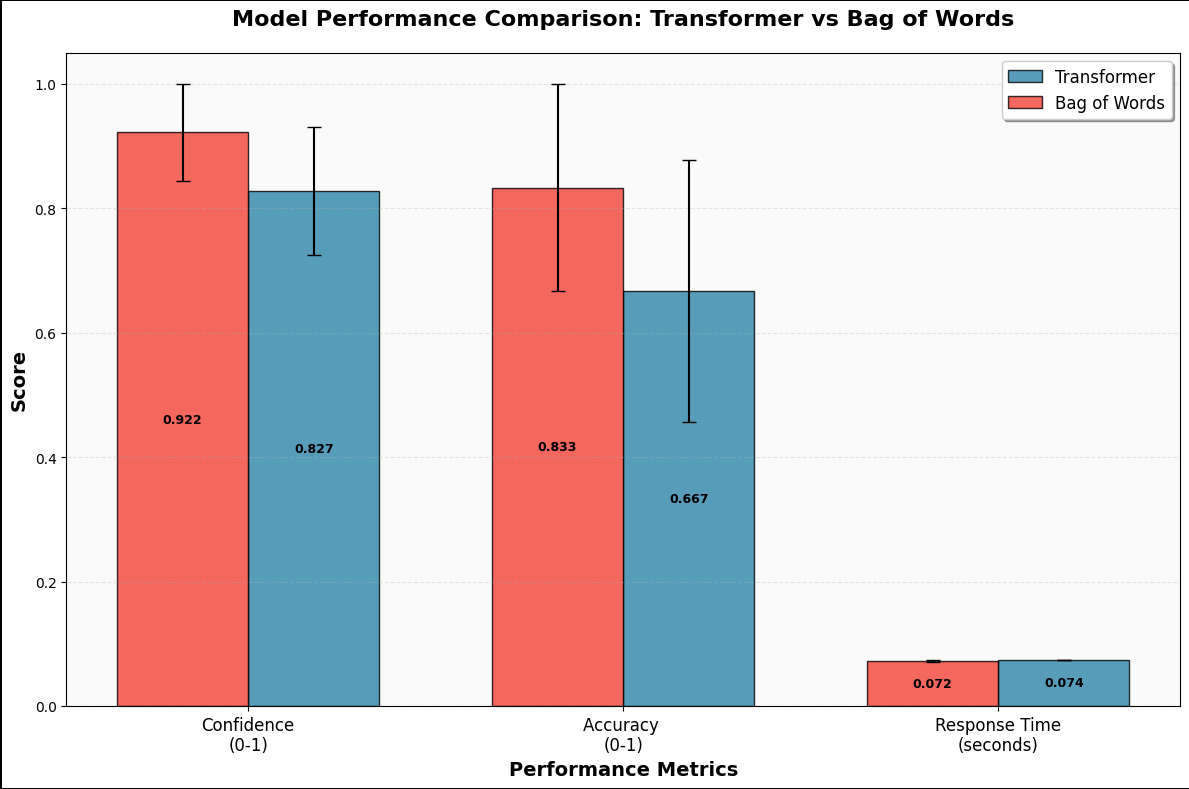

=== SUMMARY STATISTICS ===
NOTE: BOW speed calculation excludes first value (5.65s outlier)
Transformer - Mean Confidence: 0.827 ± 0.103
Bag of Words - Mean Confidence: 0.922 ± 0.078
Transformer - Accuracy: 0.667 ± 0.211
Bag of Words - Accuracy: 0.833 ± 0.167
Transformer - Mean Response Time: 0.074s ± 0.001s
Bag of Words - Mean Response Time: 0.072s ± 0.002s (n=5, outlier excluded)

=== STATISTICAL SIGNIFICANCE (T-TESTS) ===
Confidence (0-1): t=-0.739, p=0.477 ns
Relevance (0-1): t=-0.620, p=0.549 ns
Response Time (s) (outlier excluded): t=1.028, p=0.334 ns

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [101]:
# compartive graphic

# Convert string columns to numeric
for col in ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']:
    df_transformer[col] = pd.to_numeric(df_transformer[col])
    df_bow[col] = pd.to_numeric(df_bow[col])

# et outliers to nan for time calculations (first response takes much longer for both models)
df_bow.loc[0, 'Response Time (s)'] = np.nan  
df_transformer.loc[0, 'Response Time (s)'] = np.nan

# Drop outliers
bow_speed_clean = df_bow['Response Time (s)'].dropna()
transformer_speed_clean = df_transformer['Response Time (s)'].dropna()

# Calculate summary statistics for each model
metrics = ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']
transformer_means = [df_transformer[metric].mean() for metric in metrics[:2]] # Relevance and Confidence
bow_means = [df_bow[metric].mean() for metric in metrics[:2]]
transformer_means.append(transformer_speed_clean.mean()) # Response time with outlier removed
bow_means.append(bow_speed_clean.mean())


# Calculate standard errors (you can also use std() for standard deviation)
transformer_errors = [df_transformer[metric].std() / np.sqrt(len(df_transformer)) for metric in metrics[:2]]
bow_errors = [df_bow[metric].std() / np.sqrt(len(df_bow)) for metric in metrics[:2]]
transformer_errors.append(transformer_speed_clean.std() / np.sqrt(len(transformer_speed_clean))) # Append Response time error
bow_errors.append(bow_speed_clean.std() / np.sqrt(len(bow_speed_clean)))

# Create the grouped bar chart
plt.style.use('default') 
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
x = np.arange(len(metrics))
width = 0.35

# Create bars
bars1 = ax.bar(x + width/2, transformer_means, width, 
               label='Transformer',
               color='#2E86AB',
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=transformer_errors,
               capsize=5)

bars2 = ax.bar(x - width/2, bow_means, width,
               label='Bag of Words',
               color='#F24236',
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=bow_errors,
               capsize=5)

# Customize the chart appearance
ax.set_xlabel('Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison: Transformer vs Bag of Words', 
             fontsize=16, fontweight='bold', pad=20)

# Customize x-axis labels - Display as "Response Time" but keep data as "speed"
ax.set_xticks(x)
ax.set_xticklabels(['Confidence\n(0-1)', 'Accuracy \n(0-1)', 'Response Time\n(seconds)'], # mean relevance is equal to accuracy
                   fontsize=12)

# Add legend
ax.legend(loc='upper right',
          fontsize=12,
          frameon=True,
          shadow=True,
          fancybox=True)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

# Add value labels on top of bars (optional)
def add_value_labels(bars, values, errors):
    """Add value labels inside of bars"""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
                f'{value:.3f}',
                ha='center', va='center', fontsize=9,
                fontweight='bold', color='black')
        
# value labels
add_value_labels(bars1, transformer_means, transformer_errors)
add_value_labels(bars2, bow_means, bow_errors)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a subtle background color to the plot area
ax.set_facecolor('#FAFAFA')

# border
fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')

# Save the figure
plt.savefig('first_model_comparison.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='black')

plt.show()

# Print summary statistics for reference
print("=== SUMMARY STATISTICS ===")
print("NOTE: BOW speed calculation excludes first value (5.65s outlier)")
print(f"Transformer - Mean Confidence: {transformer_means[0]:.3f} ± {transformer_errors[0]:.3f}")
print(f"Bag of Words - Mean Confidence: {bow_means[0]:.3f} ± {bow_errors[0]:.3f}")
print(f"Transformer - Accuracy: {transformer_means[1]:.3f} ± {transformer_errors[1]:.3f}")
print(f"Bag of Words - Accuracy: {bow_means[1]:.3f} ± {bow_errors[1]:.3f}")
print(f"Transformer - Mean Response Time: {transformer_means[2]:.3f}s ± {transformer_errors[2]:.3f}s")
print(f"Bag of Words - Mean Response Time: {bow_means[2]:.3f}s ± {bow_errors[2]:.3f}s (n=5, outlier excluded)")

print("\n=== STATISTICAL SIGNIFICANCE (T-TESTS) ===")
# For confidence and relevance, use all data
for i, metric in enumerate(metrics[:2]):
    t_stat, p_value = stats.ttest_ind(df_transformer[metric], df_bow[metric])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{metric}: t={t_stat:.3f}, p={p_value:.3f} {significance}")

# For speed, exclude the outlier
t_stat, p_value = stats.ttest_ind(transformer_speed_clean, bow_speed_clean)
significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
print(f"Response Time (s) (outlier excluded): t={t_stat:.3f}, p={p_value:.3f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")




## Transformer vs Bag of Words analysis

Immediately the Bag of words model outshines the transformer as expected from looking at the tables, achieving a 25% higher mean relevance at higher average confidence. From theory this is somewhat surprising given that the transformer model is a more complex network however it did achieve a mean response time of 61% of its counterpart. The transformer showed a heavy bias toward predicting the capabilities intent. Further investigation suggests that whenever the input intent is not a greeting, farewell, or thanks (e.g., a joke or age query), the transformer consistently misclassifies it. I rarely observe it correctly identify these intents, which highlights a serious issue that must be addressed.  
Possible causes include:  
- Training data imbalance – the transformer may have been exposed to more "capabilities examples", leading to over-prediction of this class and under trained on other more niche classes.  
- Overfitting/ underfitting – the model may not have learned to effectively distinguish between different intent patterns.  
- Feature representation +  Model complexity mismatch – the bag-of-words approach may actually be better suited for this task, since it relies on key discriminative words (e.g., “help” → help intent, “joke” → joke intent). For a relatively simple intent classification task, the transformer’s complexity may be counterproductive, where as the simpler bag-of-words model captures the essential mappings more directly.

However from the T-tests performed it was found that there isn't any statisticaly significant difference between the metrics meaning the the differences could have been due to random chance.

I will attempt to improve the transformer model until it is able to perform statistically better before considering the possibility that the transformer is inherently less effective for this type of basic conversational intent classification.

## Improvements
In order to improve the model I increased the amount of training data available to it so that it can generalise for each intent better. I did this by tripling the original data creation method for most intents and by 5 times for the trickier intents it was struggling on. As now the model is recieving lots more training data collected from its intent listing there is the danger that it is overfitted. To combat this i added a data augmentation method that will remove words, shuffle words or change letters randomly to create more variation in the dataset so that the model is efficiently trained. Another reason for implementing data augmentation is that the model should be more prepared for a realistic text conversation with typos and errors. I have also improved the complexity of the model by doubling the embedded and feed-forward dimensions aswell as quadrupling the number of attention heads and implementing learning rate scheduling. The improved archetecture of the model should increase the models ability to recognise patterns in the training data. Here are the results using the previous test conversation.

In [102]:
# advanced transformer Data

df_adv_transformer = pd.read_csv("adv_Transformer_small_test_data.csv") # ... _small_ ... to indicate this table is of smaller sample size
display(df_adv_transformer)
print("Previous Transformer Data for Comparison: (ignore the 0th row outlier)")
display(df_transformer)

,Advanced Transformer,Predicted Intent,True intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,prompt 1,greeting,greeting,0.999438,1,0.072000
1,prompt 2,help,help,0.936880,1,0.072000
2,prompt 3,capabilities,capabilities,0.998799,1,0.071000
3,prompt 4,joke,joke,0.999595,1,0.069001
4,prompt 5,thanks,thanks,0.997306,1,0.069001
5,prompt 6,name,goodbye,0.990384,0,0.069001


Previous Transformer Data for Comparison: (ignore the 0th row outlier)


,Transformer,Predicted intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,Prompt 1,greeting,1.000,1,NaN
1,Prompt 2,capabilities,0.575,0,0.0750
2,Prompt 3,capabilities,0.954,1,0.0732
3,Prompt 4,capabilities,0.440,0,0.0755
4,Prompt 5,thanks,1.000,1,0.0740
5,Prompt 6,goodbye,0.994,1,0.0729


The new model has clearly outperformed the previous one with improvements in all fields. The advanced model was able to accurately predict more of the intents and maintained a higher confidence, however the one it miss profiled was done with a high accuracy which can signal a red flag as previously described. Below find a visual comparison between the bag of words model, old and new transformer models.

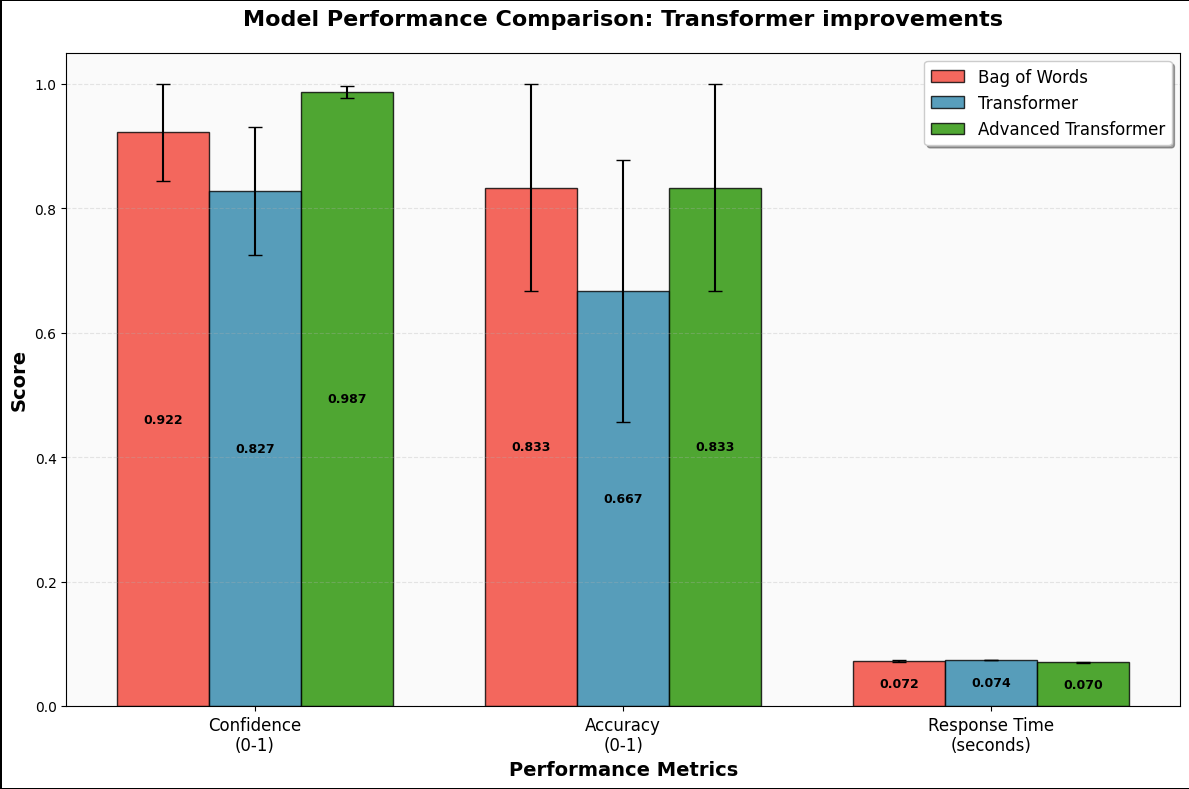

=== SUMMARY STATISTICS ===

Bow - Mean Confidence: 0.922 ± 0.078
Transformer - Mean Confidence: 0.827 ± 0.103
Advanced - Mean Confidence: 0.987 ± 0.010

Bow - Mean relevance: 0.833 ± 0.167
Transformer - Mean Relevance: 0.667 ± 0.211
Advanced  - Mean Relevance: 0.833 ± 0.167

Bow - Mean Response Time: 0.072 ± 0.002s
Transformer - Mean Response Time: 0.074s ± 0.001s
Advanced  - Mean Response Time: 0.070s ± 0.001s 

=== STATISTICAL SIGNIFICANCE (T-TESTS) ===
Confidence (0-1): t=0.826, p=0.428 ns
Relevance (0-1): t=0.000, p=1.000 ns
Response Time (s) : t=-0.864, p=0.410 ns

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [103]:
# compartive graphic 2

# Convert string columns to numeric
for col in ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']:
    df_adv_transformer[col] = pd.to_numeric(df_adv_transformer[col])

# Calculate summary statistics for each model
metrics = ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']
adv_means = [df_adv_transformer[metric].mean() for metric in metrics]

# Calculate standard errors
adv_errors = [df_adv_transformer[metric].std() / np.sqrt(len(df_adv_transformer)) for metric in metrics]

# Create the grouped bar chart
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.25

# Create bars

bars1 = ax.bar(x - width, bow_means, width,
               label='Bag of Words',
               color='#F24236',
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=bow_errors,
               capsize=5)

bars2 = ax.bar(x, transformer_means, width, 
               label='Transformer',
               color='#2E86AB',  
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=transformer_errors,
               capsize=5)

bars3 = ax.bar(x + width, adv_means, width,
               label='Advanced Transformer',
               color="#249100",
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=adv_errors,
               capsize=5)

# chart appearance
ax.set_xlabel('Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison: Transformer improvements', 
             fontsize=16, fontweight='bold', pad=20)

# x-axis labels - Display as "Response Time" but keep data as "speed"
ax.set_xticks(x)
ax.set_xticklabels(['Confidence\n(0-1)', 'Accuracy\n(0-1)', 'Response Time\n(seconds)'], 
                   fontsize=12)

# Add legend
ax.legend(loc='upper right',
          fontsize=12,
          frameon=True,
          shadow=True,
          fancybox=True)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.3, axis='y')


# Add value labels on top of bars
def add_value_labels(bars, values, errors):
    """Add value labels on top of bars"""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
                f'{value:.3f}',
                ha='center', va='center', fontsize=9,
                fontweight='bold', color='black')

# Uncomment to add value labels
add_value_labels(bars1, bow_means, bow_errors)
add_value_labels(bars2, transformer_means, transformer_errors)
add_value_labels(bars3, adv_means, adv_errors)


# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a subtle background color to the plot area
ax.set_facecolor('#FAFAFA')

# Add a professional border around the entire figure
fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')

#save the figure
plt.savefig('improvemets_comparison.png', dpi=300, bbox_inches='tight',
             facecolor='white', edgecolor='black')

plt.show()

# Print summary statistics for reference
print("=== SUMMARY STATISTICS ===")
print(f"\nBow - Mean Confidence: {bow_means[0]:.3f} ± {bow_errors[0]:.3f}")
print(f"Transformer - Mean Confidence: {transformer_means[0]:.3f} ± {transformer_errors[0]:.3f}")
print(f"Advanced - Mean Confidence: {adv_means[0]:.3f} ± {adv_errors[0]:.3f}")

print(f"\nBow - Mean relevance: {bow_means[1]:.3f} ± {bow_errors[1]:.3f}")
print(f"Transformer - Mean Relevance: {transformer_means[1]:.3f} ± {transformer_errors[1]:.3f}")
print(f"Advanced  - Mean Relevance: {adv_means[1]:.3f} ± {adv_errors[1]:.3f}")

print(f"\nBow - Mean Response Time: {bow_means[2]:.3f} ± {bow_errors[2]:.3f}s")
print(f"Transformer - Mean Response Time: {transformer_means[2]:.3f}s ± {transformer_errors[2]:.3f}s")
print(f"Advanced  - Mean Response Time: {adv_means[2]:.3f}s ± {adv_errors[2]:.3f}s ")

print("\n=== STATISTICAL SIGNIFICANCE (T-TESTS) ===")
# For confidence and relevance, use all data
for i, metric in enumerate(metrics[:2]):
    t_stat, p_value = stats.ttest_ind(df_adv_transformer[metric], df_bow[metric])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{metric}: t={t_stat:.3f}, p={p_value:.3f} {significance}")

# For speed, exclude the outlier
t_stat, p_value = stats.ttest_ind(df_adv_transformer['Response Time (s)'], bow_speed_clean)
significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
print(f"Response Time (s) : t={t_stat:.3f}, p={p_value:.3f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

## Transformer Improvements Analysis
The graphic indicates that the transformer model with recent improvements outperforms the bag-of-words model in terms of average confidence, while achieving comparable results on mean response time and accuracy. Although initially the transformer model appears to be at an advantage, t-tests suggests that the observed differences are not significant and may be down to random variation. It is also important to note that the evaluation was conducted on a limited set of intents that feature in the file, which does not fully capture the models’ capabilities. To address this, I constructed a new test set following the same criteria as the original, but not in a conversational sequence. Specifically, ten new unique messages for each intent, yielding a total of 120 samples for a more robust comparison between the models.

In [104]:
# Large smaple size data frames

df_BOW_large = pd.read_csv("BOW_test_data.csv")
display(df_BOW_large)

df_transformer_large = pd.read_csv("Transformer_test_data.csv")
display(df_transformer_large)

df_adv_transformer_large = pd.read_csv("Adv_Transformer_large_test_data.csv")
display(df_adv_transformer_large)

,Bag of words,Predicted Intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,prompt 1,greeting,0.999960,1,5.954944
1,prompt 2,greeting,0.999957,1,0.073021
2,prompt 3,greeting,0.999999,1,0.074999
3,prompt 4,greeting,0.999998,1,0.072000
4,prompt 5,greeting,0.999954,1,0.072001
...,...,...,...,...,...
115,prompt 116,age,1.000000,1,0.070000
116,prompt 117,age,1.000000,1,0.072999
117,prompt 118,age,0.999999,1,0.071002
118,prompt 119,age,0.999999,1,0.070000


,Transformer,Predicted Intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,prompt 1,greeting,0.999804,1,0.322997
1,prompt 2,greeting,0.999874,1,0.068998
2,prompt 3,greeting,0.999800,1,0.068000
3,prompt 4,greeting,0.999853,1,0.069041
4,prompt 5,greeting,0.999876,1,0.069000
...,...,...,...,...,...
115,prompt 116,how_are_you,0.994136,0,0.068001
116,prompt 117,how_are_you,0.863943,0,0.068001
117,prompt 118,capabilities,0.999265,0,0.068001
118,prompt 119,capabilities,0.506891,0,0.069000


,Advanced Transformer,Predicted Intent,True intent,Confidence (0-1),Relevance (0-1),Response Time (s)
0,prompt 1,greeting,greeting,0.999365,1,0.422558
1,prompt 2,greeting,greeting,0.999420,1,0.073140
2,prompt 3,greeting,greeting,0.999128,1,0.072035
3,prompt 4,greeting,greeting,0.999377,1,0.071970
4,prompt 5,greeting,greeting,0.686681,1,0.072999
...,...,...,...,...,...,...
115,prompt 116,age,age,0.998266,1,0.069000
116,prompt 117,age,age,0.998369,1,0.069001
117,prompt 118,age,age,0.998436,1,0.069001
118,prompt 119,age,age,0.998369,1,0.070000


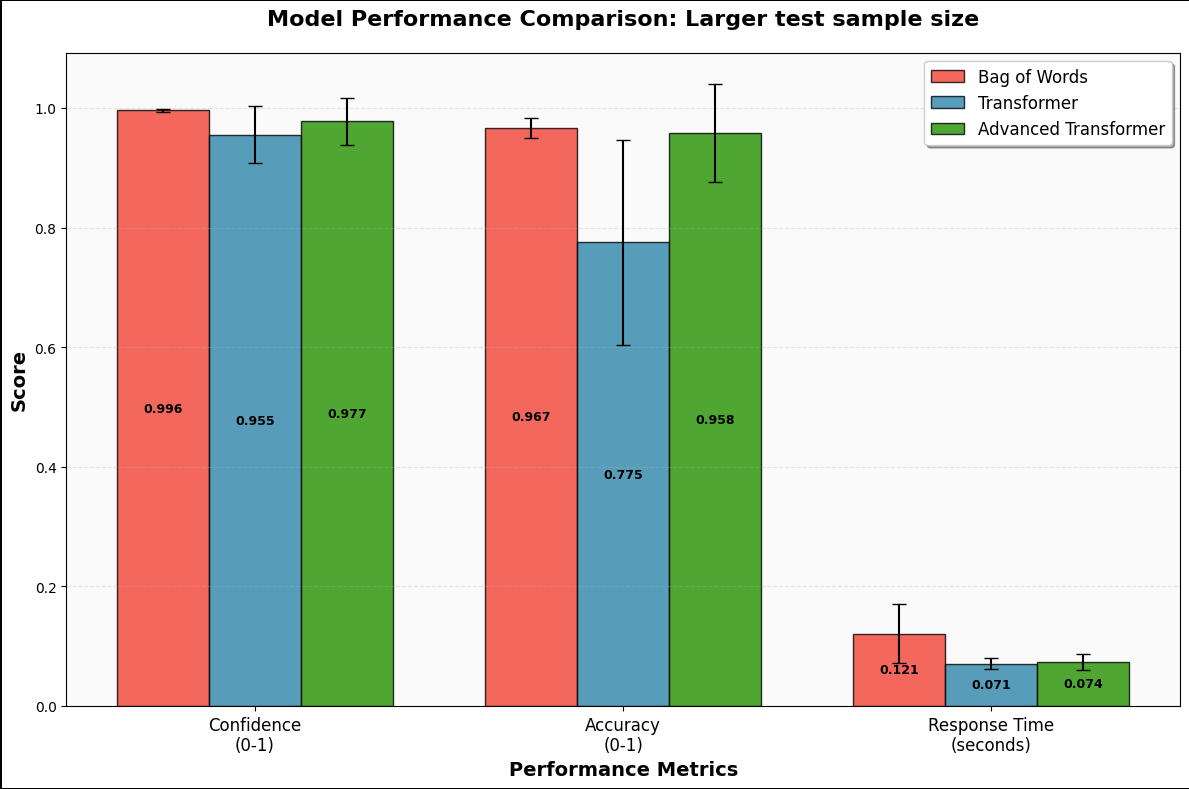

=== SUMMARY STATISTICS ===
Transformer - Mean Confidence: 0.955 ± 0.048
Advanced - Mean Confidence: 0.977 ± 0.039
Bow - Mean Confidence: 0.996 ± 0.003
Transformer - Mean Relevance: 0.775 ± 0.171
Advanced  - Mean Relevance: 0.958 ± 0.082
Bow - Mean relevance: 0.967 ± 0.016
Transformer - Mean Response Time: 0.071s ± 0.009s
Advanced  - Mean Response Time: 0.074s ± 0.013s 
Bow - Mean Response Time: 0.121 ± 0.049s


In [105]:
# compartive graphic (3) Larger sample size

# Convert string columns to numeric
for col in ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']:
    df_BOW_large[col] = pd.to_numeric(df_BOW_large[col])
    df_adv_transformer_large[col] = pd.to_numeric(df_adv_transformer_large[col])
    df_transformer_large[col] = pd.to_numeric(df_transformer_large[col])
    

# Calculate summary statistics for each model (including initial response time due to larger sample size - lack of effect))
metrics = ['Confidence (0-1)', 'Relevance (0-1)', 'Response Time (s)']
bow_means = [df_BOW_large[metric].mean() for metric in metrics]
transformer_means = [df_transformer_large[metric].mean() for metric in metrics]
adv_means = [df_adv_transformer_large[metric].mean() for metric in metrics]


# Calculate standard errors (you can also use std() for standard deviation)
bow_errors = [df_BOW_large[metric].std() / np.sqrt(len(df_BOW_large)) for metric in metrics]
transformer_errors = [df_transformer_large[metric].std() / np.sqrt(len(df_transformer)) for metric in metrics]
adv_errors = [df_adv_transformer_large[metric].std() / np.sqrt(len(df_adv_transformer)) for metric in metrics]


# Create the grouped bar chart
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.25

# Create bars

bars1 = ax.bar(x - width, bow_means, width,
               label='Bag of Words',
               color='#F24236',
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=bow_errors,
               capsize=5)

bars2 = ax.bar(x, transformer_means, width, 
               label='Transformer',
               color='#2E86AB',  
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=transformer_errors,
               capsize=5)

bars3 = ax.bar(x + width, adv_means, width,
               label='Advanced Transformer',
               color="#249100",
               alpha=0.8,
               edgecolor='black',
               linewidth=1,
               yerr=adv_errors,
               capsize=5)

# chart appearance
ax.set_xlabel('Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison: Larger test sample size', 
             fontsize=16, fontweight='bold', pad=20)

# x-axis labels - Display as "Response Time" but keep data as "speed"
ax.set_xticks(x)
ax.set_xticklabels(['Confidence\n(0-1)', 'Accuracy\n(0-1)', 'Response Time\n(seconds)'], 
                   fontsize=12)

# Add legend
ax.legend(loc='upper right',
          fontsize=12,
          frameon=True,
          shadow=True,
          fancybox=True)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.3, axis='y')


# Add value labels on top of bars
def add_value_labels(bars, values, errors):
    """Add value labels on top of bars"""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
                f'{value:.3f}',
                ha='center', va='center', fontsize=9,
                fontweight='bold', color='black')

# Uncomment to add value labels
add_value_labels(bars1, bow_means, bow_errors)
add_value_labels(bars2, transformer_means, transformer_errors)
add_value_labels(bars3, adv_means, adv_errors)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a subtle background color to the plot area
ax.set_facecolor('#FAFAFA')

# Add a professional border around the entire figure
fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')

#save the figure
plt.savefig('Larger_sample_graphic.png', dpi=300, bbox_inches='tight',
             facecolor='white', edgecolor='black')

plt.show()

# Print summary statistics for reference
print("=== SUMMARY STATISTICS ===")
print(f"Transformer - Mean Confidence: {transformer_means[0]:.3f} ± {transformer_errors[0]:.3f}")
print(f"Advanced - Mean Confidence: {adv_means[0]:.3f} ± {adv_errors[0]:.3f}")
print(f"Bow - Mean Confidence: {bow_means[0]:.3f} ± {bow_errors[0]:.3f}")
print(f"Transformer - Mean Relevance: {transformer_means[1]:.3f} ± {transformer_errors[1]:.3f}")
print(f"Advanced  - Mean Relevance: {adv_means[1]:.3f} ± {adv_errors[1]:.3f}")
print(f"Bow - Mean relevance: {bow_means[1]:.3f} ± {bow_errors[1]:.3f}")
print(f"Transformer - Mean Response Time: {transformer_means[2]:.3f}s ± {transformer_errors[2]:.3f}s")
print(f"Advanced  - Mean Response Time: {adv_means[2]:.3f}s ± {adv_errors[2]:.3f}s ")
print(f"Bow - Mean Response Time: {bow_means[2]:.3f} ± {bow_errors[2]:.3f}s")


## Larger Sample Size Analysis

The results reinforce the earlier observation that the improved transformer model performs on par with the bag-of-words model. While the BoW model demonstrates slightly higher averages and lower variance in both accuracy and confidence, the most notable distinction lies in response time; the advanced transformer achieves a mean response time 39% lower than its competitor—a difference far more pronounced than in the other metrics. However, this advantage is unlikely to be perceptible to an end user, with the exception of the BoW model’s initial response, which has consistently approached six seconds in all tests. Another key takeaway is that the new transformer exhibits a clear improvement over its predecessor, with accuracy increasing by 23% while maintaining comparable response times and achieving marginally higher confidence. In the context of conversational AI, accuracy is the most critical metric, as it directly determines the likelihood of producing an appropriate response and thereby sustaining coherent dialogue. Taken together, these results suggest that the improved transformer advances upon its prior version and also provides equal competition to its rival model, perhaps stronger where user error is considered.

## Conclusion

This project initially compared a simple bag-of-words chatbot with a baseline transformer model, in which the comparative analysis revealed several key findings. Suprisingly the basic bag-of-words outperformed the transformer model across the board. The transformer suffered from low accuracy, oftenly misclassifying the test messages intentions, highlighting the need for architectural refinements. After identifying solutions to these shortfallings and multtiple iteraions I was able to produce an improved Transformer model. By incorporating these targeted changes, it achieved a 23% improvement in accuracy relative to its predecessor while maintaining high confidence scores and faster response times. Although the bag-of-words approach still edged out the Transformer in raw accuracy, the gap was modest, and the Transformer’s scalability, adaptability, and efficiency make it a more robust foundation for future development.

Overall, this work demonstrates that careful model design can advance performance, speed and conversational reliability. The improved Transformer not only narrows the gap with the bag-of-words model but also establishes itself as a more future-ready architecture inherently. Further refinements, such as expanding training data, optimizing intent representation, and expanding the intents file, could yield even greater gains, ultimately supporting more responsive and effective conversational AI systems.